SRN 230713176 <br>
ST2195 Coursework <br>
Part 2 (a) & (b)

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [ ]:
# read csv files
airplanes = pd.read_csv("plane-data.csv")
airports = pd.read_csv("airports.csv")
carriers = pd.read_csv("carriers.csv")

In [26]:
# using necessary columns to save memory
cols = ['Year','Month','DayofMonth','DayOfWeek',
        'CRSDepTime','CRSArrTime','DepTime','ArrTime',
        'DepDelay','ArrDelay','Cancelled','CancellationCode',
        'TailNum','UniqueCarrier','Origin','Dest','Distance']

In [ ]:
df_1 = pd.read_csv("2000.csv", usecols=cols, encoding='ISO-8859-1')
df_2 = pd.read_csv("2001.csv", usecols=cols, encoding='ISO-8859-1')
df_3 = pd.read_csv("2002.csv", usecols=cols, encoding='ISO-8859-1')
df_4 = pd.read_csv("2003.csv", usecols=cols, encoding='ISO-8859-1')
df_5 = pd.read_csv("2004.csv", usecols=cols, encoding='ISO-8859-1')

In [15]:
# check data shape across all years before combining
for i, df in enumerate([df_1, df_2, df_3, df_4, df_5], start=1):
    print(f"df_{i} shape: {df.shape}")

df_1 shape: (5683047, 17)
df_2 shape: (5967780, 17)
df_3 shape: (5271359, 17)
df_4 shape: (6488540, 17)
df_5 shape: (7129270, 17)


In [16]:
# combine all dataframes
dfs = pd.concat([df_1, df_2, df_3, df_4, df_5], ignore_index=True)

In [17]:
# check datatypes
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30539996 entries, 0 to 30539995
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Year              int64  
 1   Month             int64  
 2   DayofMonth        int64  
 3   DayOfWeek         int64  
 4   DepTime           float64
 5   CRSDepTime        int64  
 6   ArrTime           float64
 7   CRSArrTime        int64  
 8   UniqueCarrier     object 
 9   TailNum           object 
 10  ArrDelay          float64
 11  DepDelay          float64
 12  Origin            object 
 13  Dest              object 
 14  Distance          int64  
 15  Cancelled         int64  
 16  CancellationCode  object 
dtypes: float64(4), int64(8), object(5)
memory usage: 3.9+ GB


In [18]:
# drop rows with missing values NA's
dfs = dfs.dropna(subset=['DepTime', 'CRSDepTime', 'Year', 'Month', 'DayofMonth'])

In [19]:
dfs.shape

(29826939, 17)

In [20]:
# checkg number of cancelled flights
len(dfs[dfs['Cancelled'] == 1])

0

In [21]:
# create a new file with combined years for efficiency
dfs.to_parquet('flight data.parquet', index=False)

In [3]:
df = pd.read_parquet('flight data.parquet')

## Question (a) <br> To minimize flight delay, when is the best: <br>
a.1 **time** of day <br> a.2 **day** of week <br> a.3 **month** of year? (bonus)

### a.1 Best **time** of day to minimize delays

In [4]:
# combine delay-related variables
df['ArrDepDelay'] = df['ArrDelay'] + df['DepDelay']

In [5]:
df = df[df['ArrDepDelay'] >=0 ].sort_values(by = ('ArrDepDelay')) # filter values to exclude early arr/dep

In [7]:
# find average delay by time
time_delay = df.groupby('CRSDepTime').mean(numeric_only=True).reset_index()

In [8]:
# show results
print("\nLowest average delay times:")
print(time_delay[['CRSDepTime', 'ArrDepDelay']].sort_values('ArrDepDelay').head(10))


Lowest average delay times:
     CRSDepTime  ArrDepDelay
121         240     0.000000
136         445     0.000000
105         207     0.000000
160         526     3.653846
130         330     4.000000
3             3     4.800000
137         450     5.000000
135         440     5.000000
94          144     6.000000
152         518     7.770642


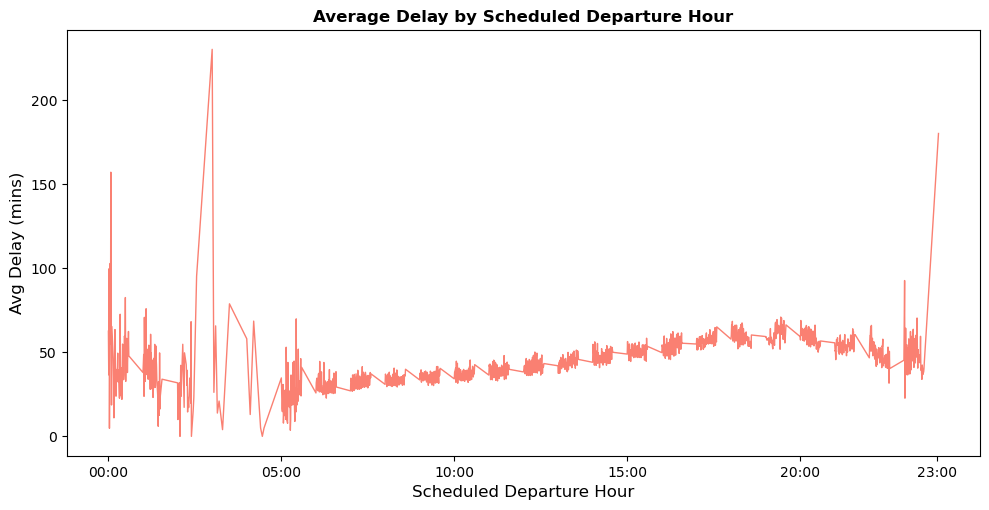

In [ ]:
# visualize results
plt.figure(figsize=(10,5))
plt.plot(time_delay['CRSDepTime'], time_delay['ArrDepDelay'], linewidth=1, color='salmon')

tick_positions = [0, 500, 1000, 1500, 2000, 2395]
tick_labels = ['00:00', '05:00', '10:00', '15:00', '20:00', '23:00'] # for clearer time labels

plt.xticks(tick_positions, tick_labels)
plt.xlabel('Scheduled Departure Hour', fontsize=12)
plt.ylabel('Avg Delay (mins)', fontsize= 12)
plt.tight_layout()
plt.title('Average Delay by Scheduled Departure Hour', fontsize=12, fontweight='bold')
plt.savefig('coeffs_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [94]:
# smallest average delay (best time)
best_time = time_delay.loc[time_delay['ArrDepDelay'].idxmin(), 'CRSDepTime']

In [99]:
# convert into better format
hours = int(best_time) // 100
minutes = int(best_time) % 100
best_time_2 = f"{hours:02d}:{minutes:02d}"

In [100]:
print(f"\nBest flight time of the day: {best_time_2}")


Best flight time of the day: 02:07


### a.2 Best **day** of week to minimize delays

In [ ]:
# find average delay by day
day_delay = df.groupby('DayOfWeek').mean(numeric_only=True).reset_index()

In [23]:
# show results
print("\nAvg delay by day:")
days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

for idx, row in day_delay.iterrows():
    day_num = int(row['DayOfWeek'])
    print(f" {days_of_week[day_num - 1]}: {row['ArrDepDelay']:.2f} minutes")


Avg delay by day:
 Sunday: 43.86 minutes
 Monday: 40.82 minutes
 Tuesday: 42.01 minutes
 Wednesday: 45.50 minutes
 Thursday: 47.40 minutes
 Friday: 40.28 minutes
 Saturday: 45.27 minutes


In [29]:
# switch day numbers into names
day_delay['DayOfWeek'] = day_delay['DayOfWeek'].astype(int)
day_delay['DayName'] = day_delay['DayOfWeek'].map(lambda x: days_of_week[x-1])

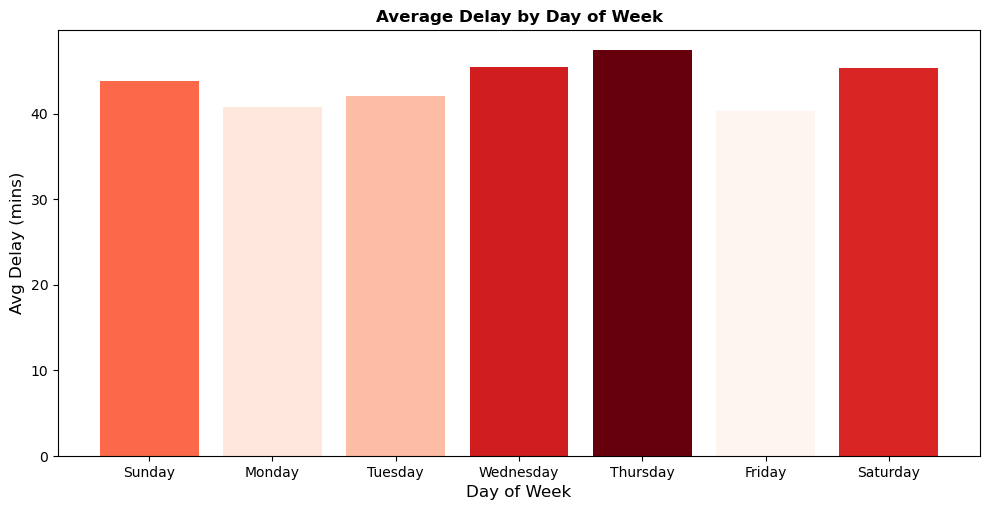

In [86]:
# visualize results
plt.figure(figsize=(10,5))

# normalizing the delays to apply color gradient (light=low, dark=high)
norm_day = plt.Normalize(vmin=day_delay['ArrDepDelay'].min(), vmax=day_delay['ArrDepDelay'].max())
gradient_day = plt.cm.Reds(norm_day(day_delay['ArrDepDelay']))

plt.bar(day_delay['DayName'], day_delay['ArrDepDelay'], color=gradient_day)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Avg Delay (mins)', fontsize= 12)
plt.tight_layout()
plt.title('Average Delay by Day of Week', fontsize=12, fontweight='bold')
plt.show()

In [36]:
best_day_idx = day_delay['ArrDepDelay'].idxmin()
best_day_of_week = day_delay.loc[best_day_idx, 'DayName']

In [44]:
# show lowest average delay day
print(f"\n Best flight day of week: {best_day_of_week}")
print(f" Avg delay: {day_delay.loc[best_day_idx, 'ArrDepDelay']:.2f} minutes")


 Best flight day of week: Friday
 Avg delay: 40.28 minutes


### a.3 Best **month** of year to minimize delays (bonus)

In [52]:
# find average delay by month
month_delay = df.groupby('Month')['ArrDepDelay'].mean().reset_index()
month_delay.head(12)

,Month,ArrDepDelay
0,1,41.314470
1,2,42.251701
2,3,40.940250
3,4,39.738232
4,5,44.150646
5,6,50.451170
6,7,49.045596
7,8,48.200533
8,9,39.981568
9,10,36.758865


In [54]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [ ]:
# map month numbers into their corresponing names
month_delay['MonthName'] = month_delay['Month'].map(lambda x: months[int(x)-1])

In [58]:
# show results
print("\nLowest average delay months:")
months_sorted = month_delay.sort_values('ArrDepDelay')
print(months_sorted[['MonthName', 'ArrDepDelay']].head(12))


Lowest average delay months:
   MonthName  ArrDepDelay
9        Oct    36.758865
3        Apr    39.738232
8        Sep    39.981568
10       Nov    40.333855
2        Mar    40.940250
0        Jan    41.314470
1        Feb    42.251701
4        May    44.150646
7        Aug    48.200533
11       Dec    48.614341
6        Jul    49.045596
5        Jun    50.451170


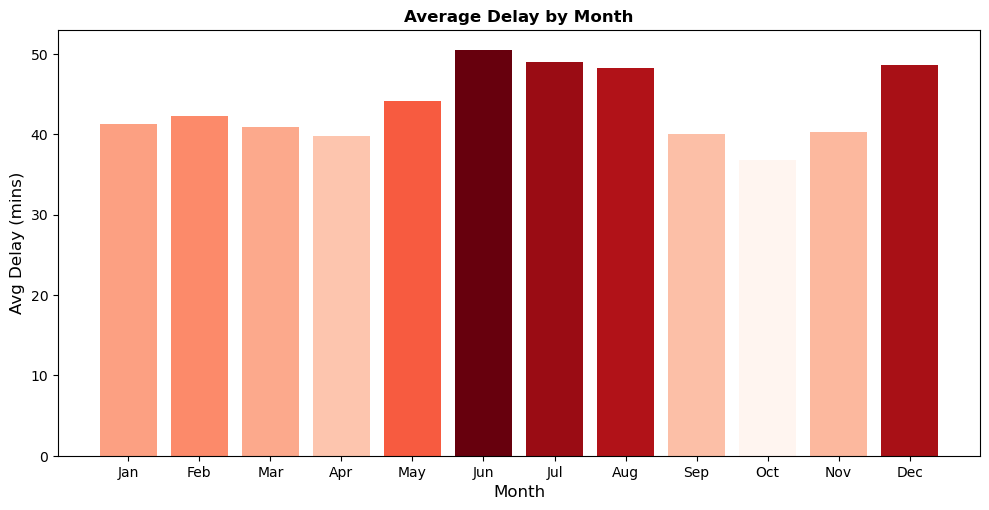

In [ ]:
# visualize results
plt.figure(figsize=(10,5))

# normalizing the delays to apply color gradient (light=low, dark=high)
norm = plt.Normalize(vmin=month_delay['ArrDepDelay'].min(), vmax=month_delay['ArrDepDelay'].max())
gradient = plt.cm.Reds(norm(month_delay['ArrDepDelay']))

plt.bar(month_delay['Month'], month_delay['ArrDepDelay'], color=gradient)
plt.xticks(range(1, 13), months)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Avg Delay (mins)', fontsize= 12)
plt.tight_layout()
plt.title('Average Delay by Month', fontsize=12, fontweight='bold')
plt.show()

In [ ]:
# find best month
best_month_row = months_sorted.iloc[0]
best_month_num = int(best_month_row['Month'])
best_month = months[best_month_num - 1]

print(f"\n Best flight month: {best_month}")
print(f" Avg delay: {best_month_row['ArrDepDelay']:.2f} minutes")


 Best flight month: Oct
 Avg delay: 36.76 minutes


### Overall Conclusion

In [103]:
print("Best flight times to minimize delays:")
print(f" >Best time of day: {best_time_2}")
print(f" >Best day of week: {best_day_of_week}")
print(f" >Best month of year: {best_month}")

Best flight times to minimize delays:
 >Best time of day: 02:07
 >Best day of week: Friday
 >Best month of year: Oct


## Question (b) <br> Do older planes suffer more delays?

In [6]:
# merge plane data with flight data
merged = df.merge(airplanes.rename(columns={'tailnum': 'TailNum'}), how='left', on='TailNum', copy=False) # fix column name differences

In [7]:
# calculate plane age by subtracting manufacturing year from flight year
merged['plane_age'] = merged['Year'] - merged['year']

In [8]:
# get rid of invalid manufacturing years
merged = merged[(merged['year'] != '0000') &
                (merged['year'] != 'None') &
                (merged['year'].notna()) &
                (merged['year'] > 1900)]

In [9]:
merged['year'] = merged['year'].astype(int)

In [10]:
# average delay by manufacturing year

manuf_delay = merged.groupby('year').agg({'ArrDepDelay': 'mean',
                                          'TailNum': 'count'}).rename(columns={'TailNum': 'num_flights'}).reset_index()

In [15]:
print("\nManufacturing years with the lowest avg delay:")
print(manuf_delay.nsmallest(5, 'ArrDepDelay')[['year', 'ArrDepDelay']])


Manufacturing years with the lowest avg delay:
    year  ArrDepDelay
1   1957    32.343137
35  1995    39.037011
36  1996    39.411330
33  1993    41.290907
41  2001    41.451964


In [69]:
print("\nManufacturing years with the highest avg delay:")
print(manuf_delay.nlargest(5, 'ArrDepDelay')[['year', 'ArrDepDelay']])


Manufacturing years with the highest avg delay:
    year  ArrDepDelay
0   1956    61.389978
13  1972    56.367010
22  1982    55.749689
5   1964    53.927453
2   1959    53.662613


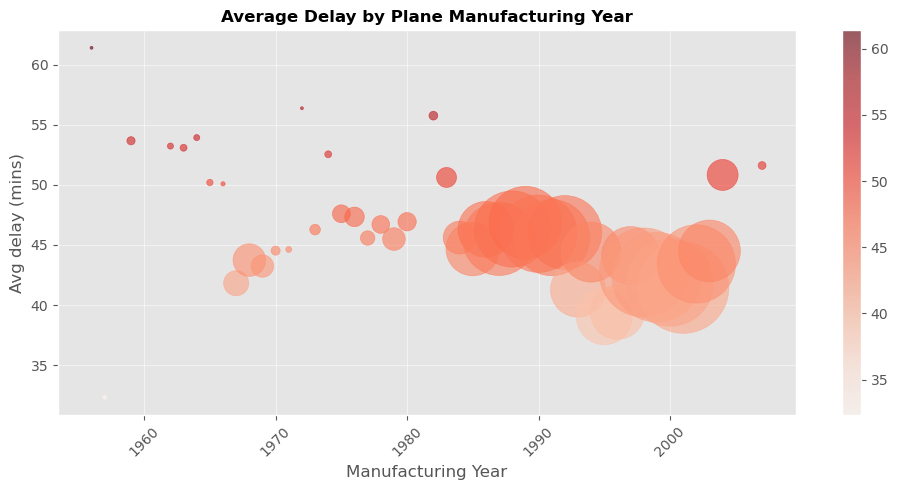

In [28]:
# create visualization
plt.figure(figsize=(10,5))
plt.style.use('ggplot')

# PLOT 1: average delay by manufacturing year
scatter1 = plt.scatter(
    manuf_delay['year'],
    manuf_delay['ArrDepDelay'],
    s=manuf_delay['num_flights']/100, # scaling size of bubbles by number of flights
    c=manuf_delay['ArrDepDelay'],
    cmap='Reds',
    alpha=0.6
)
plt.xlabel('Manufacturing Year', fontsize=12)
plt.ylabel('Avg delay (mins)', fontsize=12)
plt.title('Average Delay by Plane Manufacturing Year', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.5)
cbar = plt.colorbar(scatter1) 

plt.tight_layout()
plt.show()

### Statistical analysis

In [16]:
# average delay by plane age

age_delay = merged.groupby('plane_age').agg({'ArrDepDelay': 'mean',
                                          'TailNum': 'count'}).rename(columns={'TailNum': 'num_flights'}).reset_index()

In [17]:
# split into old and new planes
age_threshold = 20 # 20 years
merged['plane_category'] = merged['plane_age'].apply(lambda x: 'Old' if x >= age_threshold else 'New')

In [18]:
# calculate proprortion of delayed flights in old vs new planes
merged['is_delayed'] = merged['ArrDepDelay'] > 15 #15 minutes

In [19]:
for category in ['Old', 'New']:
    cat_data = merged[merged['plane_category'] == category]
    print(f"\n{category} Planes:")
    print(f"Total flights: {len(cat_data):}")
    print(f"Average delay: {cat_data['ArrDepDelay'].mean():.2f} minutes")
    print(f"Proportion delayed: {cat_data['is_delayed'].mean():.3f}")


Old Planes:
Total flights: 281106
Average delay: 45.79 minutes
Proportion delayed: 0.527

New Planes:
Total flights: 5161998
Average delay: 43.89 minutes
Proportion delayed: 0.519


In [20]:
# calculate proprortion of delayed flights old vs new planes
delayed_new = merged.loc[merged['plane_age'] < age_threshold]['ArrDepDelay'].dropna()
delayed_old = merged.loc[merged['plane_age'] >= age_threshold]['ArrDepDelay'].dropna()

In [21]:
# perform t-test
t_statistic, p_value = ttest_ind(delayed_old, delayed_new, equal_var=False)

print(f"\n t-test results:")
print(f" t-stat: {t_statistic:.4f}")
print(f" p-value: {p_value:.6f}")


 t-test results:
 t-stat: 11.0769
 p-value: 0.000000


In [22]:
if p_value < 0.05:
    print("t-test result: statistically significant")
    print("older planes have statistically different delays than new ones")
else:
        print("t-test result: no statistical significance")
        print("no statistical evidence of difference in delays in new vs old planes")

t-test result: statistically significant
older planes have statistically different delays than new ones


### Year by year analysis

In [23]:
results_by_year = []
for flight_year in sorted(merged['Year'].unique()):
    year_data = merged[merged['Year'] == flight_year]

    old_year = year_data[year_data['plane_age'] >= age_threshold]
    new_year = year_data[year_data['plane_age'] < age_threshold]

    pr_delayed_old = old_year['is_delayed'].mean()
    pr_delayed_new = new_year['is_delayed'].mean()

    if len(old_year) > 0 and len(new_year) > 0:
        t_stat_year, p_value_year = ttest_ind(
            old_year['ArrDepDelay'].dropna(),
            new_year['ArrDepDelay'].dropna(),
            equal_var=False
        )

        results_by_year.append({
            'Year': flight_year,
            'pr_delayed_old': pr_delayed_old,
            'pr_delayed_new': pr_delayed_new,
            't-stat': t_stat_year,
            'p-value': p_value_year,
            'significance': p_value_year < 0.05
    })

In [24]:
results_df = pd.DataFrame(results_by_year)

In [79]:
print("\nYear by year analysis:")
for _, row in results_df.iterrows():
    print(f"\nYear {row['Year']}:")
    print(f" Old planes delayed: {row['pr_delayed_old']:.3f}")
    print(f" New planes delayed: {row['pr_delayed_new']:.3f}")
    print(f" Significant: {'Yes' if row['significance'] else 'No'} (p={row['p-value']:.4f})")


Year by year analysis:

Year 2000:
 Old planes delayed: 0.544
 New planes delayed: 0.564
 Significant: No (p=0.9071)

Year 2001:
 Old planes delayed: 0.507
 New planes delayed: 0.500
 Significant: Yes (p=0.0254)

Year 2002:
 Old planes delayed: 0.542
 New planes delayed: 0.492
 Significant: Yes (p=0.0000)

Year 2003:
 Old planes delayed: 0.502
 New planes delayed: 0.472
 Significant: Yes (p=0.0000)

Year 2004:
 Old planes delayed: 0.524
 New planes delayed: 0.536
 Significant: No (p=0.0504)


### Overall Conclusion

In [ ]:
#Overall Statistics by Plane Category:
overall_stats = merged.groupby('plane_category').agg({
    'ArrDepDelay': ['mean', 'median', 'std', 'count'],
    'is_delayed': 'mean'
}).round(3)

print("\nOverall Statistics by Plane Category:")
print(overall_stats)


Overall Statistics by Plane Category:
               ArrDepDelay                         is_delayed
                      mean median     std    count       mean
plane_category                                               
New                 43.885   17.0  77.112  5161998      0.519
Old                 45.788   17.0  89.284   281106      0.527


### Correlation between plane age and delays

In [22]:
# defining a function to interperate correlation

def corr_interpertation(corr):
    abs_corr = abs(corr)
    if abs_corr > 0.7:
        strength = "Strong"
    elif abs(corr) > 0.4:
        strength = "Moderate"
    else:
        strength = "Weak"
    direction = "positive" if corr > 0 else "negative"
    return f"{strength} {direction}"

In [23]:
# Year-by-year correlation
correlations = []
years_list = []

for year in range(2000, 2004):
    year_data = merged[merged['Year'] == year]
    if len(year_data) > 0:
        correlation = year_data[['plane_age', 'ArrDepDelay']].corr().iloc[0, 1]
        correlations.append(correlation)
        years_list.append(year)

        interpertation = corr_interpertation(correlation)
        print(f"Year {year}: r = {correlation:.4f} ({interpertation})")
        print(f" Older planes {'tend to have more delays' if correlation > 0 else 'do not tend to have more delays'}")

Year 2000: r = 0.0113 (Weak positive)
 Older planes tend to have more delays
Year 2001: r = 0.0283 (Weak positive)
 Older planes tend to have more delays
Year 2002: r = 0.0361 (Weak positive)
 Older planes tend to have more delays
Year 2003: r = 0.0133 (Weak positive)
 Older planes tend to have more delays
